# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np
import re
import time

import torch.utils.data as data

from torch import nn
from lightning import Trainer
from dataclasses import asdict
from typing import Optional, Sequence
from pathlib import Path

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    preprocess_hsi,
    read_fixed_labels_mask_from_path,
    pu_bin_train_test_split_by_mask,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_generic,
    plot_epoch_generic,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator, BinaryDatasetDecorator
from src.util.reporting import (
    create_model_name,
    report_run,
    read_report_to_show,
    lightning_metrics,
)
from src.util.scheduler import CosineLRSchedulerWrapper
from src.model.dbda import DBDA
from src.model.representative_datapoints_search import (
    RepresentativeDatapointsSearchAdapter,
)
from src.definitions import RAW_DATA_FOLDER, REPORTS_FOLDER
from src.model.representative_datapoints_search import RepresentativeDatapointsSearch
from src.util.loss import PULoss

2. Prepare env

In [2]:
epoch_seconds = int(time.time())

log_dir = REPORTS_FOLDER / f"bin-dbda-k-medoids-pu-{epoch_seconds}"

In [3]:
learning_rate = 1e-3
weight_decay = 0
num_epochs = 3

In [4]:
batch_size = 64
patch_size = 9
target_dim = 75
target_class = 1

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [5]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [6]:
torch.cuda.empty_cache()

In [7]:
torch.set_float32_matmul_precision("medium")

In [8]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [9]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [10]:
_, image = preprocess_hsi(image, pre_process_type)

In [11]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [12]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [13]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [14]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)

In [15]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [16]:
full_dataset = data.TensorDataset(x_tensor, y_tensor)

full_loader = data.DataLoader(
    BinaryDatasetDecorator(full_dataset, target_class),
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

4. Train model

In [17]:
def extract_prediction(y_hat):
    return (torch.sigmoid(y_hat) > 0.5).to(dtype=torch.int)

In [ ]:
class IndianPinesDatapointsSearch(
    RepresentativeDatapointsSearchAdapter[HyperSpectralImageClassifier]
):
    target_class: int

    def __init__(self, target_class):
        super().__init__()

        self.target_class = target_class

    def get_run_params(
        self,
    ) -> Sequence[
        tuple[str, data.DataLoader, Optional[data.DataLoader], dict[str, float]]
    ]:
        params = {
            "num_epochs": num_epochs,
            "learning_rate": learning_rate,
            "t_initial": num_epochs,
            "weight_decay": weight_decay,
            "lr_min": learning_rate * 0.01,
            "warmup_lr_init": learning_rate * 0.01,
            "warmup_t": int(np.ceil(0.1 * num_epochs)),
        }

        return [
            self.create_run_params(id, path, params)
            for id, path in self.load_partitions_by_class(self.target_class)
        ]

    def init_model(self, params: dict[str, float]) -> HyperSpectralImageClassifier:
        loss = nn.BCEWithLogitsLoss()

        positive_count = (y == self.target_class).sum()
        positive_prob = torch.tensor(positive_count / len(y), dtype=torch.float32)

        loss = PULoss(prior=positive_prob, nnPU=True)

        return HyperSpectralImageClassifier(
            DBDA(band=target_dim, classes=1, flatten_out=True),
            2,
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"],
            loss_fun=loss,
            pred_extractor=extract_prediction,
            scheduler=lambda optimizer: CosineLRSchedulerWrapper(
                optimizer,
                t_initial=params["num_epochs"],
                lr_min=params["lr_min"],
                warmup_t=params["warmup_t"],
                warmup_lr_init=params["warmup_lr_init"],
            ),
        )

    def fit_model(
        self,
        model: HyperSpectralImageClassifier,
        loader: data.DataLoader,
        eval_loader: data.DataLoader,
    ):
        trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

        trainer.fit(model, loader, eval_loader)

        return [asdict(it) for it in model.val_metrics]

    def score_model(
        self, model: HyperSpectralImageClassifier
    ) -> list[dict[str, float]]:
        trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

        return trainer.validate(model, full_loader)[0]

    def on_scored_model(
        self,
        id: str,
        params: dict[str, float],
        model: HyperSpectralImageClassifier,
        model_history: list[dict[str, float]],
        score: dict[str, float],
    ):
        trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

        losses = [it["loss"].cpu() for it in model_history]
        f1s = [it["f1"].cpu() for it in model_history]
        plot_epoch_generic(
            losses, desc=f"Loss for class {self.target_class} ({id} examples)"
        )
        plot_epoch_generic(
            f1s, desc=f"F1 for class {self.target_class} ({id} examples)"
        )

        y_pred = trainer.predict(model, predict_loader)
        y_pred = torch.cat(y_pred, dim=0)
        y_pred = extract_prediction(y_pred)
        y_pred = y_pred.reshape(image_h, image_w)

        plot_segmentation_comparison(
            y.reshape(image_h, image_w) == target_class, y_pred.numpy()
        )

        model_name = create_model_name(f"indian_pines_bin", {target_class: id})
        model_category = "dbda"

        run_params = {
            **params,
            "batch_size": batch_size,
            "patch_size": patch_size,
            "target_dim": target_dim,
            "pre_process_type": str(pre_process_type),
            "dim_reduction_type": str(dim_reduction_type),
        }

        report_run(
            model_name=model_name,
            model_category=model_category,
            run_desc="Default run",
            run_params=run_params | model.get_params(),
            run_metrics=lightning_metrics(score),
        )

        read_report_to_show(model_name, sort_by_metric="f1")

    def load_partitions_by_class(self, clazz: int) -> tuple[str, Path]:
        return [
            (re.search(r"-(\d+)\.npy$", str(fn)).group(1), fn)
            for fn in Path(RAW_DATA_FOLDER / "mask" / "k-medoids").glob(
                f"indian-pines-k-medoids-{clazz}-*.npy"
            )
        ]

    def create_dataloader_from_mask_file(
        self, path: Path
    ) -> tuple[data.DataLoader, data.DataLoader]:
        mask = read_fixed_labels_mask_from_path(path)

        x_train, y_train, x_test, y_test = pu_bin_train_test_split_by_mask(
            self.target_class, x, y, mask
        )

        x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
        test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)

        train_loader = data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=cpu_count,
            persistent_workers=True,
        )
        test_loader = data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=cpu_count,
            persistent_workers=True,
        )

        return train_loader, test_loader

    def create_run_params(
        self, id: str, path: Path, params: dict[str, float]
    ) -> tuple[str, data.DataLoader, data.DataLoader, dict[str, float]]:
        loader, eval_loader = self.create_dataloader_from_mask_file(path)

        return id, loader, eval_loader, params

  0%|          | 0/8 [00:00<?, ?it/s]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/hsi-classification-playground/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
---------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss           5.638840292593837e-14
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


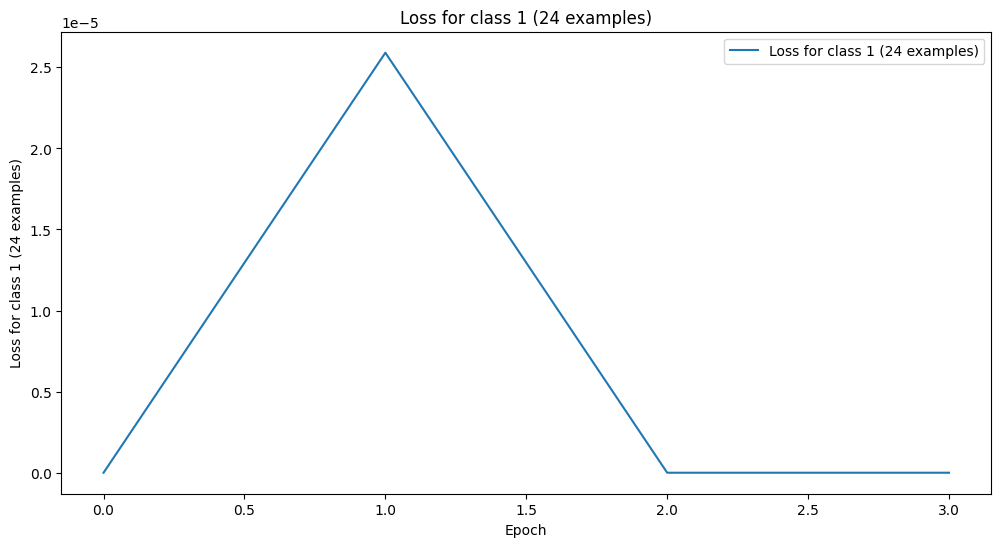

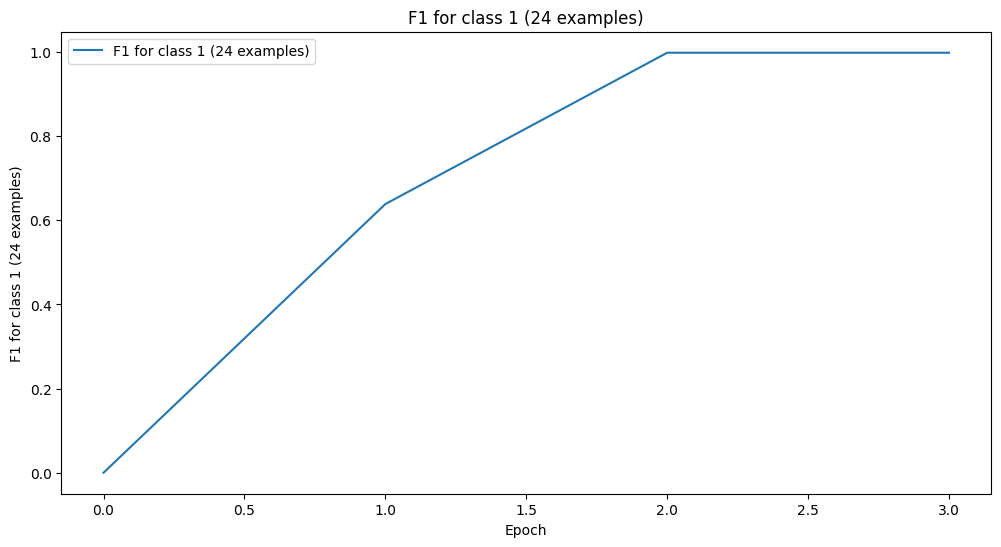

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

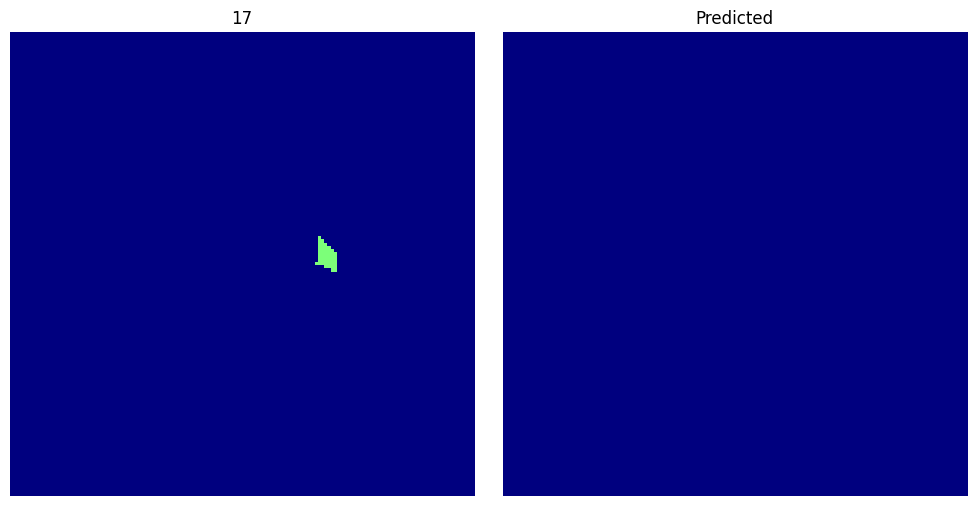

 12%|█▎        | 1/8 [00:38<04:31, 38.80s/it, id=24, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=5.64e-14, val_overall_accuracy=0.983]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss           1.997961226152256e-05
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


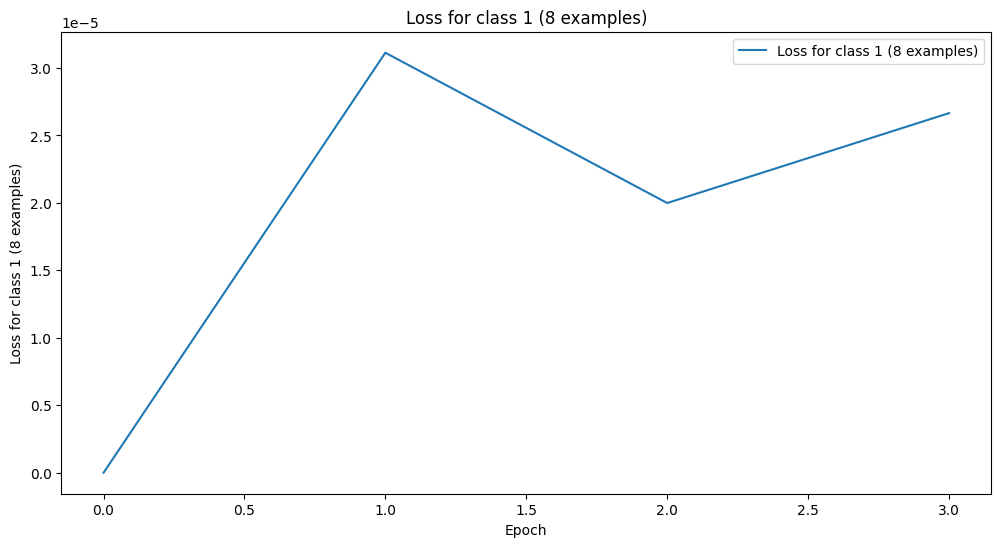

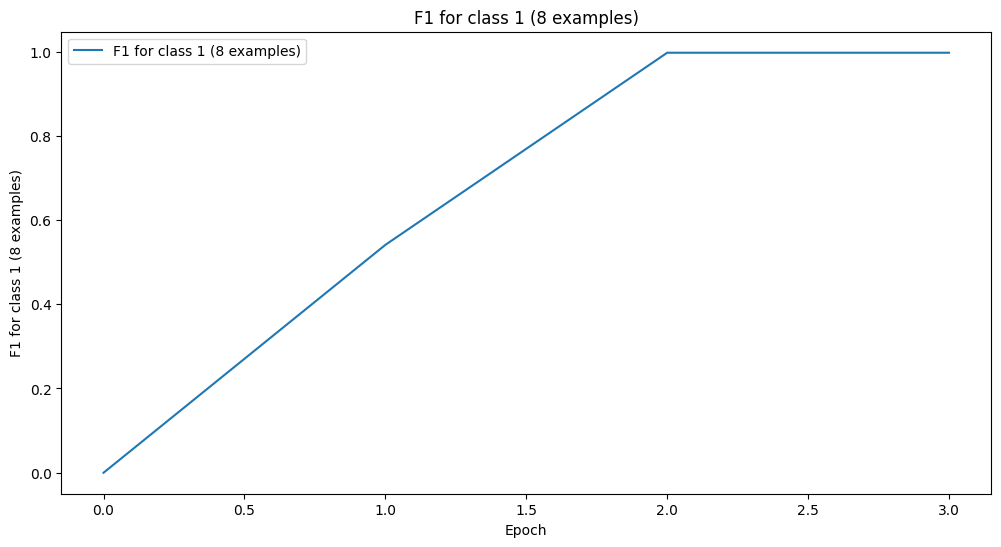

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

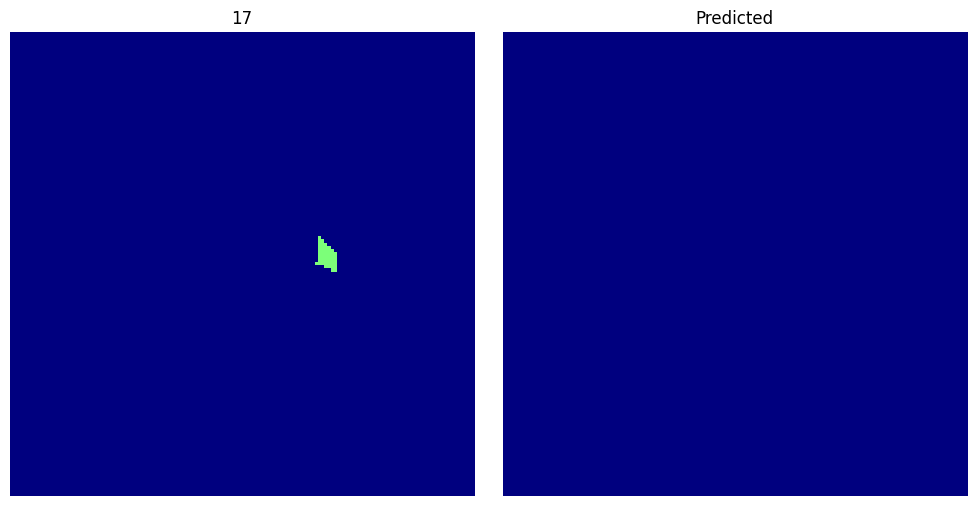

 25%|██▌       | 2/8 [01:14<03:43, 37.22s/it, id=8, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=2e-5, val_overall_accuracy=0.983]     You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss           3.020227257661295e-21
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


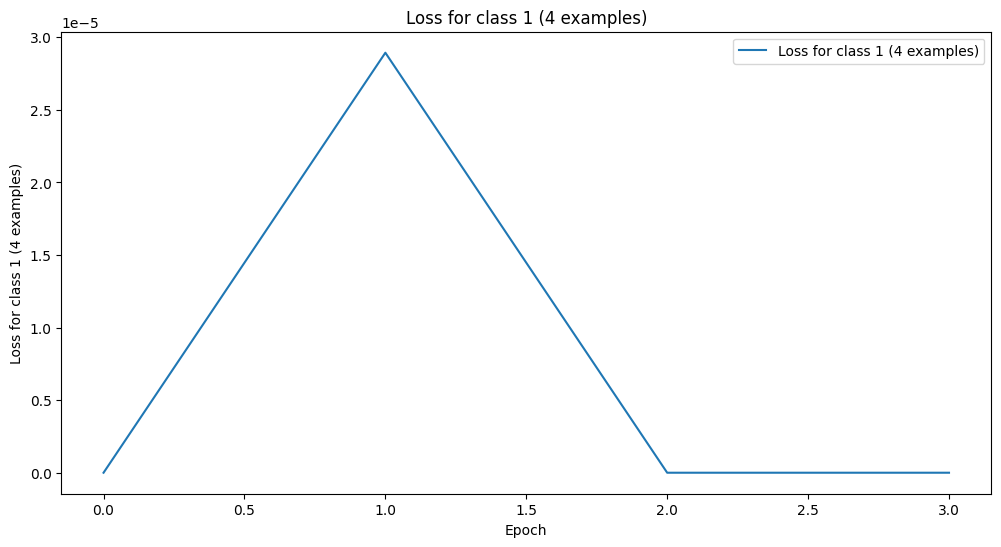

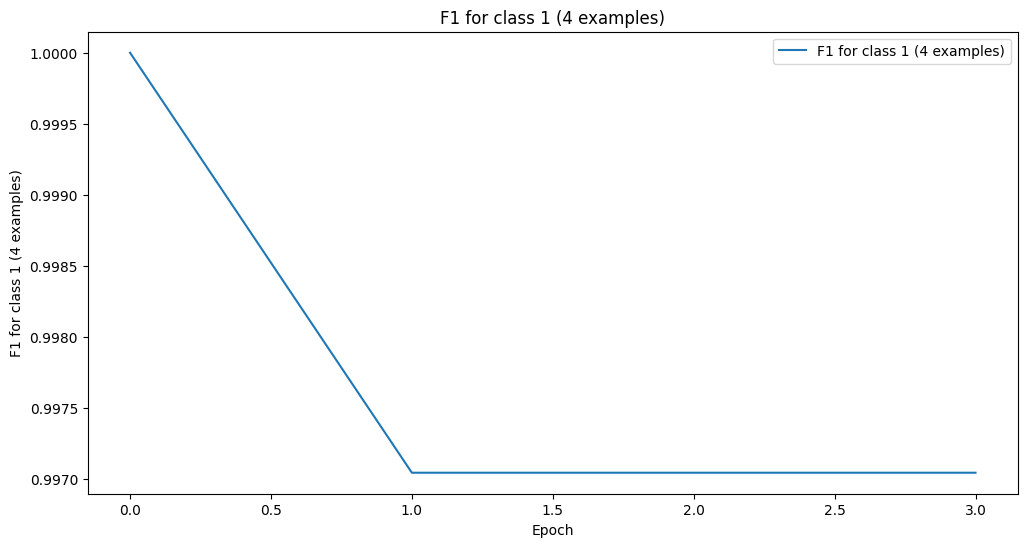

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

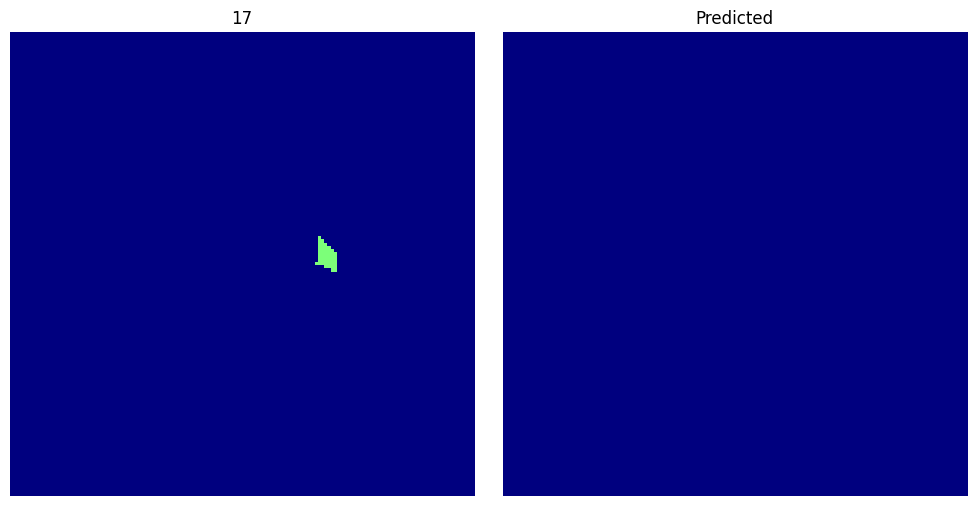

 38%|███▊      | 3/8 [01:50<03:03, 36.63s/it, id=4, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=3.02e-21, val_overall_accuracy=0.983]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
-----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss          1.1606604485023611e-15
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


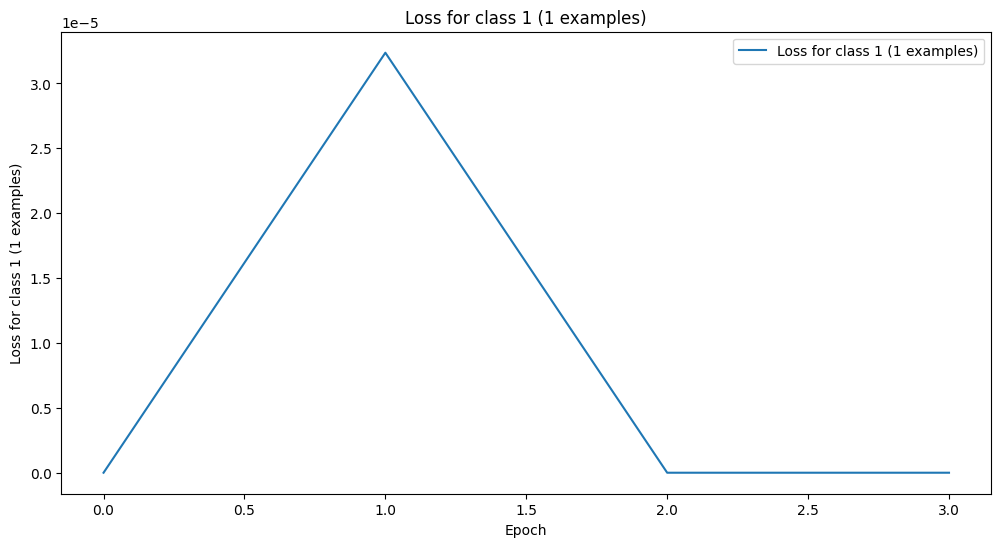

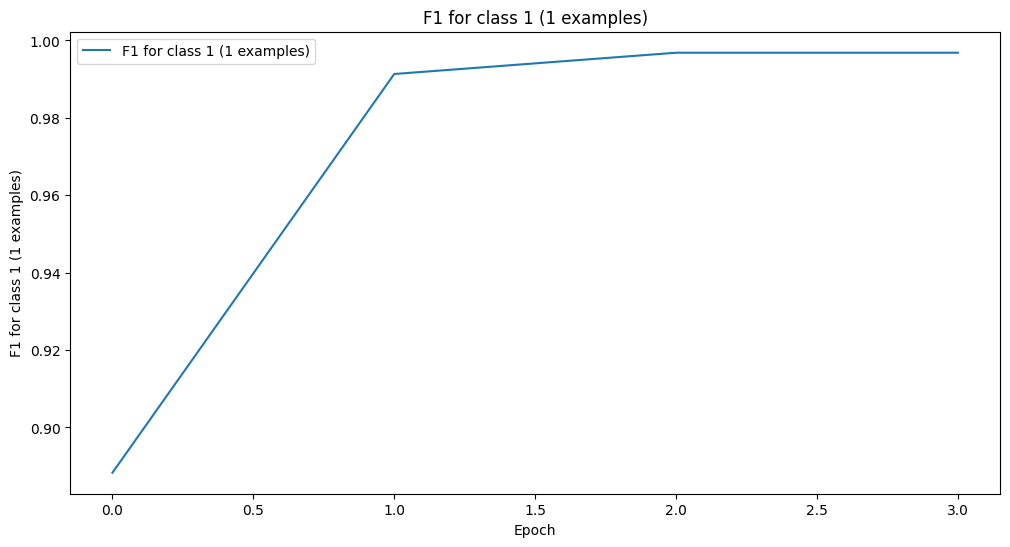

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

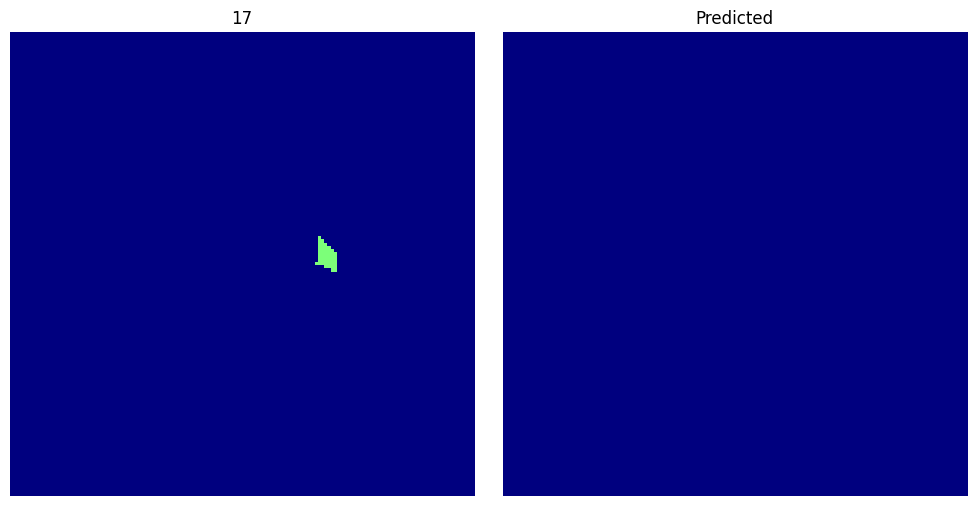

 50%|█████     | 4/8 [02:28<02:28, 37.22s/it, id=1, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=1.16e-15, val_overall_accuracy=0.983]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
-----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss          1.9128453991802035e-15
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


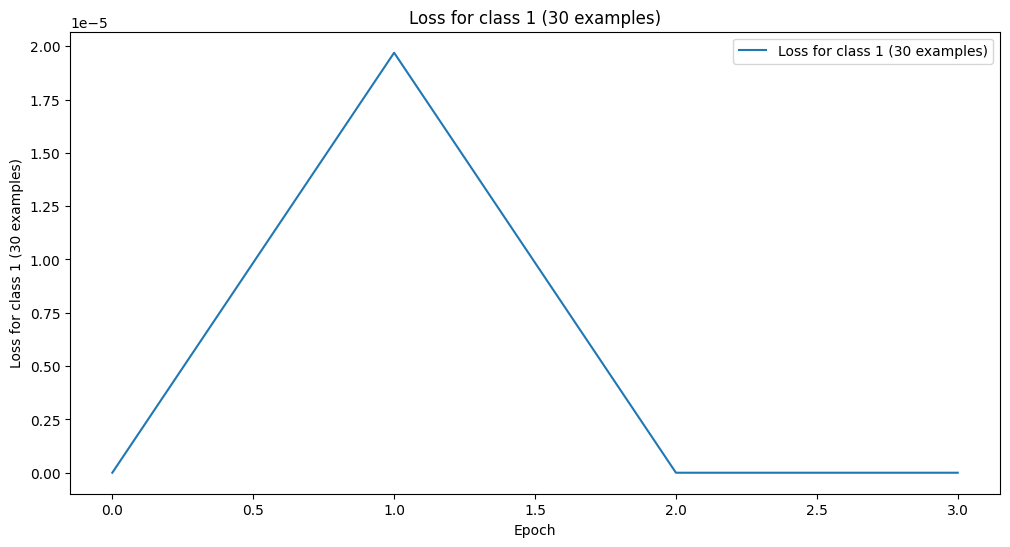

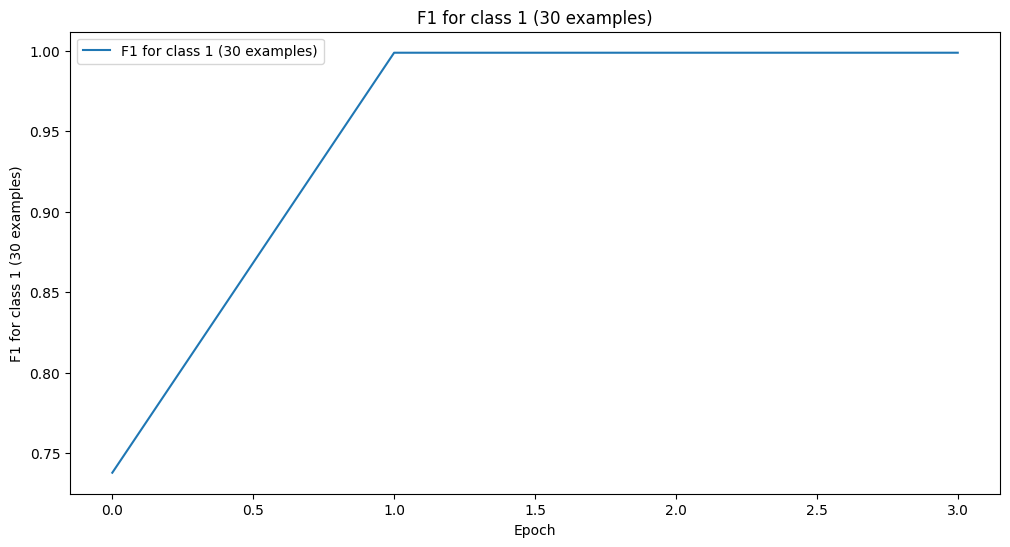

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

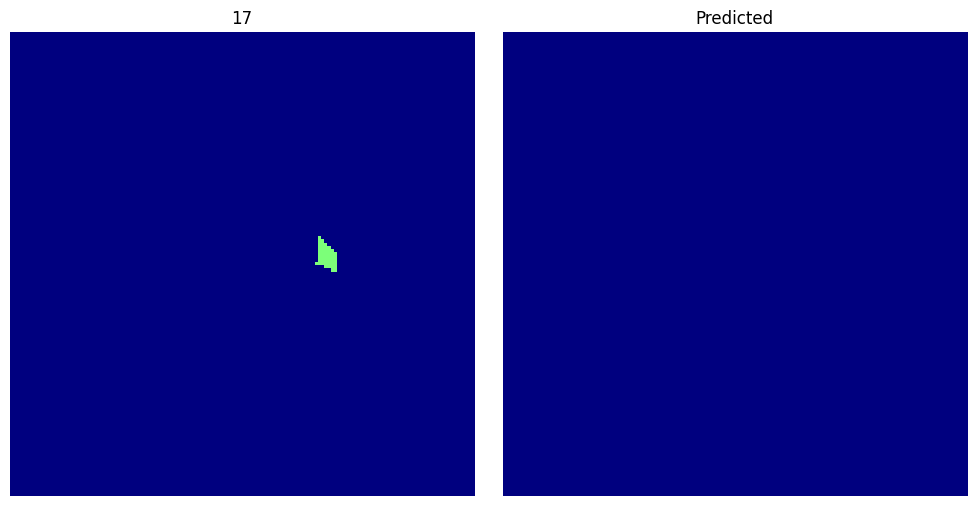

 62%|██████▎   | 5/8 [03:04<01:49, 36.48s/it, id=30, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=1.91e-15, val_overall_accuracy=0.983]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss           4.742147869608315e-18
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


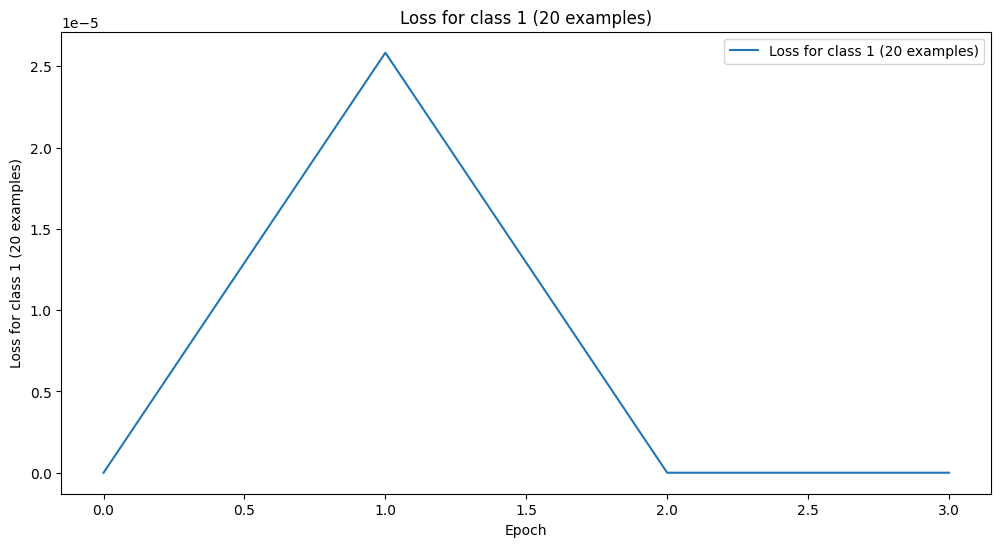

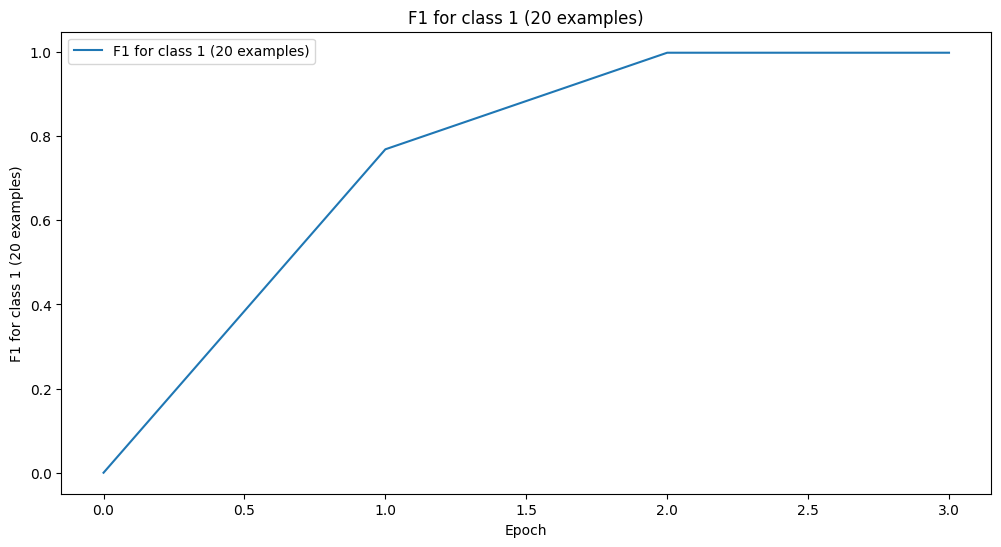

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

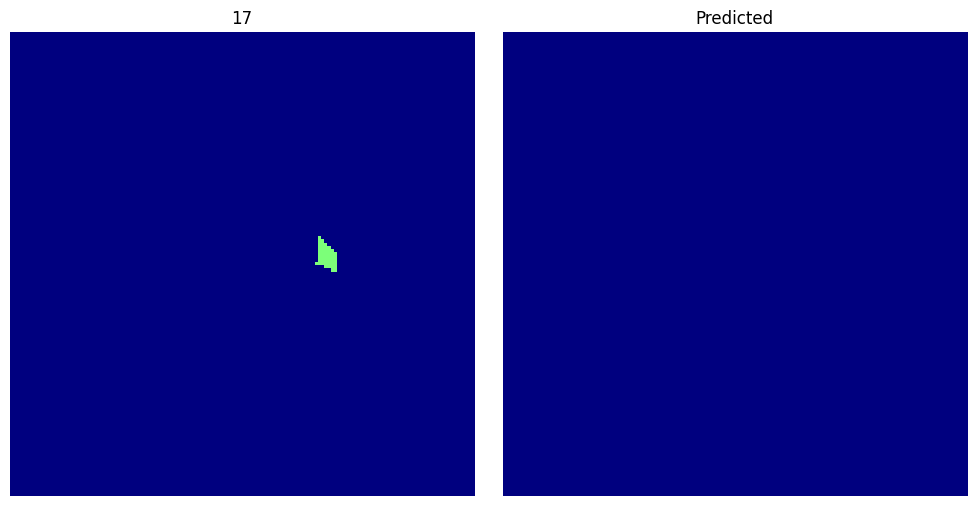

 75%|███████▌  | 6/8 [03:40<01:13, 36.60s/it, id=20, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=4.74e-18, val_overall_accuracy=0.983]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss          3.1297813445484835e-23
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


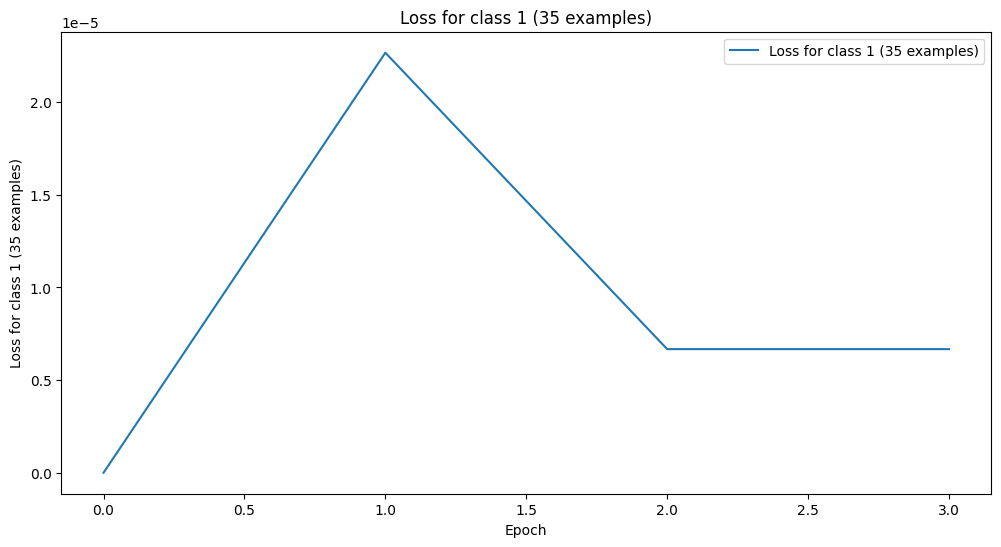

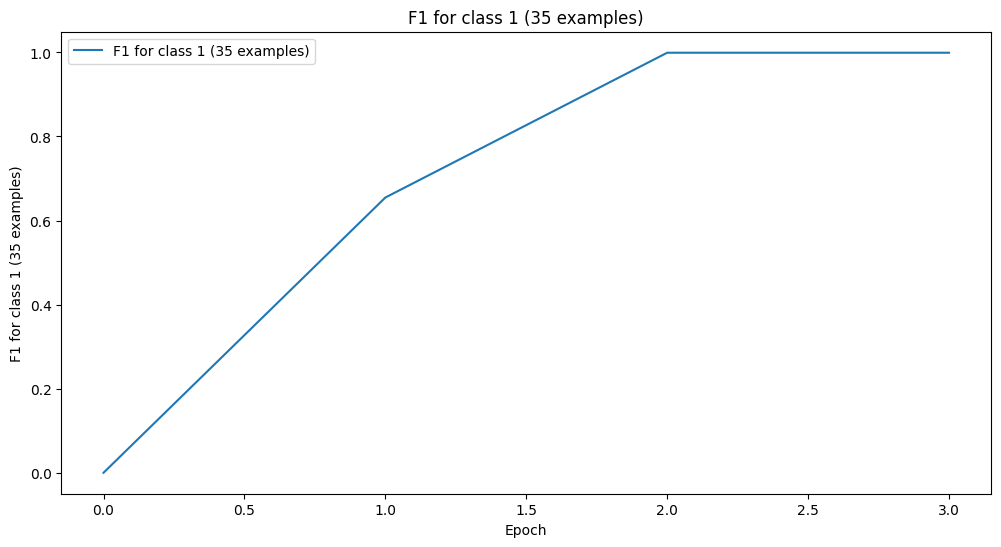

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

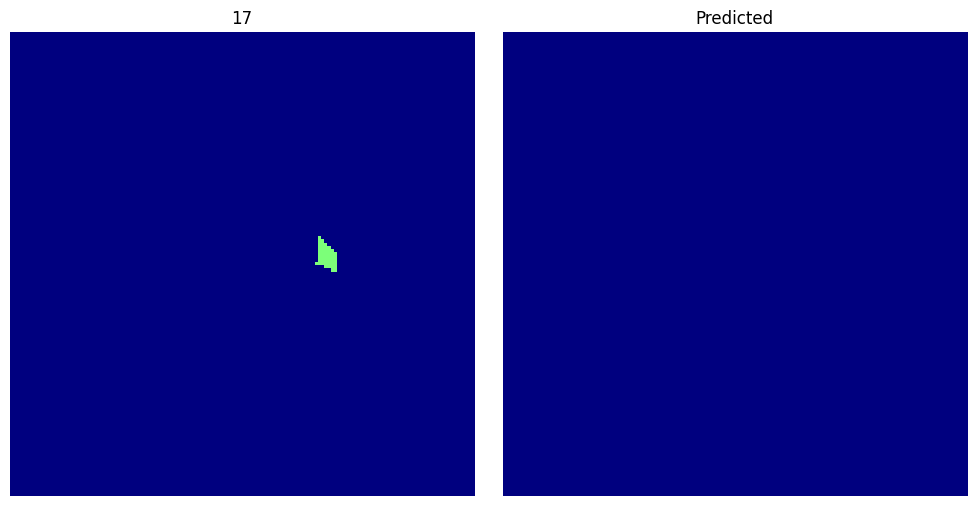

 88%|████████▊ | 7/8 [04:16<00:36, 36.30s/it, id=35, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=3.13e-23, val_overall_accuracy=0.983]You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | DBDA                 | 150 K  | train
1 | loss_fun         | PULoss               | 0      | train
2 | f1               | MulticlassF1Score    | 0      | train
3 | overall_accuracy | MulticlassAccuracy   | 0      | train
4 | average_accuracy | MulticlassAccuracy   | 0      | train
5 | kappa            | MulticlassCohenKappa | 0      | train
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.9978121519088745
         val_f1             0.9967631697654724
        val_kappa                   nan
        val_loss           5.987674800422838e-10
  val_overall_accuracy      0.9832580089569092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


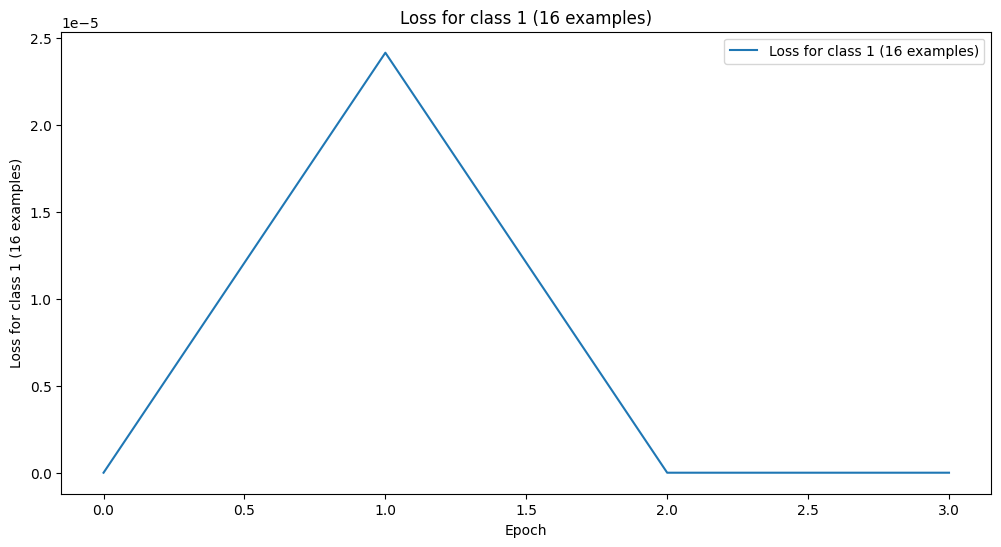

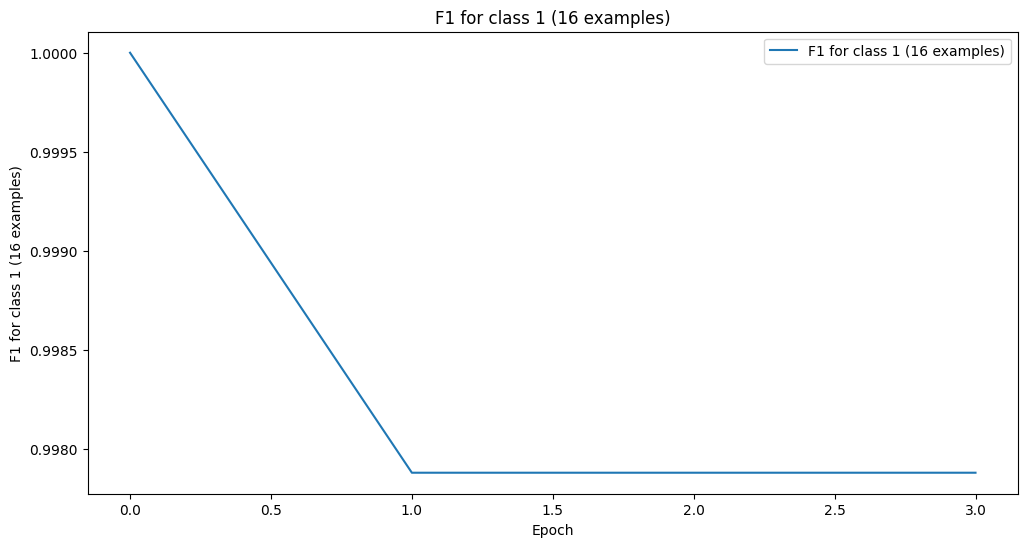

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

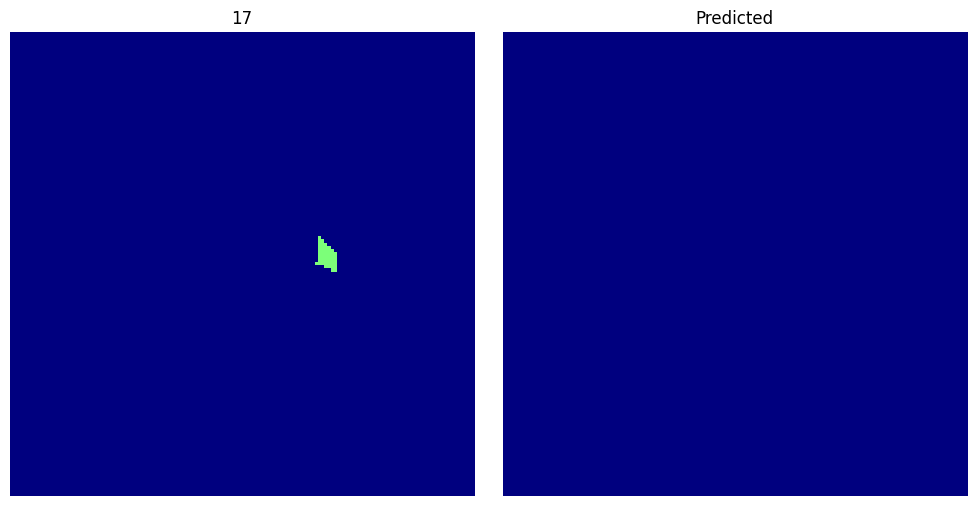

100%|██████████| 8/8 [04:52<00:00, 36.60s/it, id=16, val_average_accuracy=0.998, val_f1=0.997, val_kappa=nan, val_loss=5.99e-10, val_overall_accuracy=0.983]


In [19]:
clazz = 1

search = RepresentativeDatapointsSearch(
    IndianPinesDatapointsSearch(clazz), log_dir, f"class-{clazz}"
)

feedback = search.run()

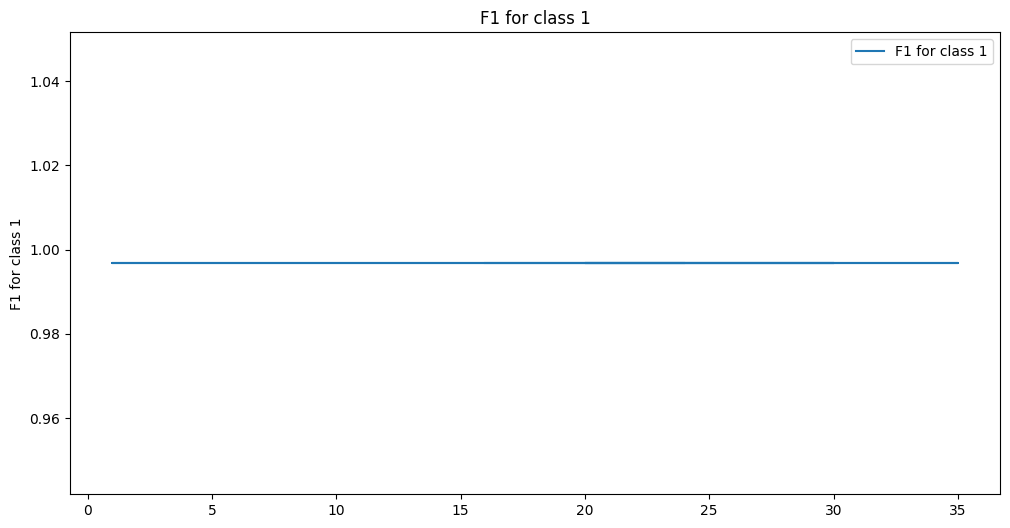

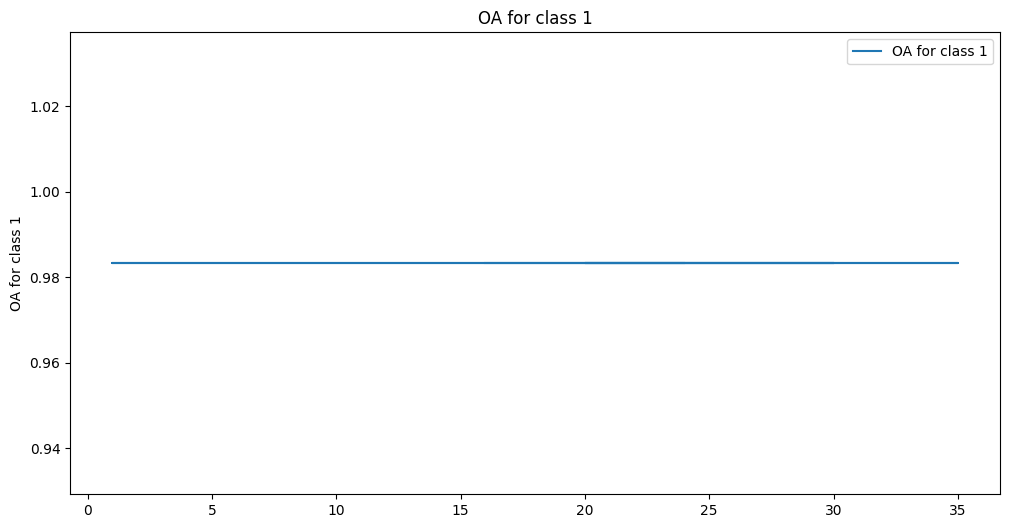

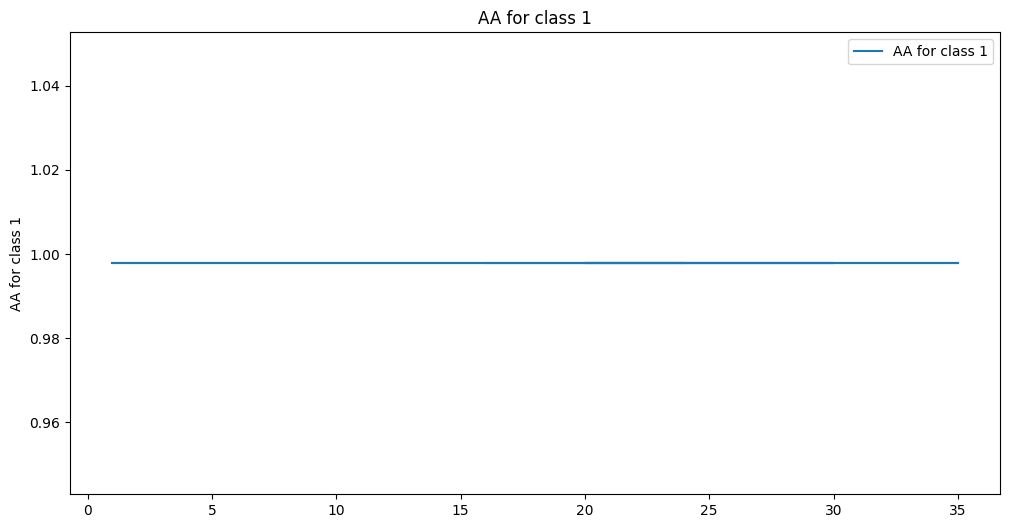

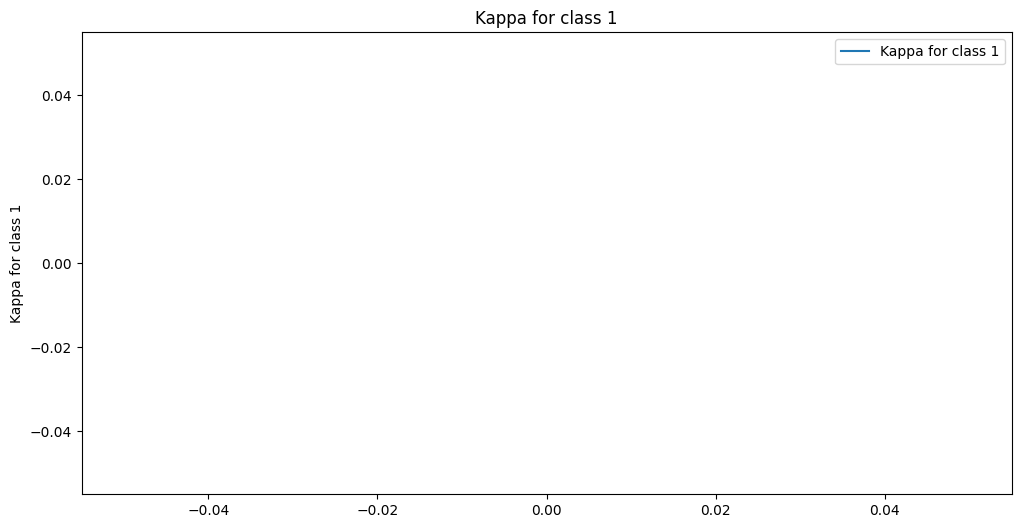

In [20]:
ids = [int(it.id) for it in feedback]
f1s = [it.score["val_f1"] for it in feedback]
oas = [it.score["val_overall_accuracy"] for it in feedback]
aas = [it.score["val_average_accuracy"] for it in feedback]
kappas = [it.score["val_kappa"] for it in feedback]

plot_generic(ids, f1s, desc=f"F1 for class {clazz}")
plot_generic(ids, oas, desc=f"OA for class {clazz}")
plot_generic(ids, aas, desc=f"AA for class {clazz}")
plot_generic(ids, kappas, desc=f"Kappa for class {clazz}")